# Step 1.Reading the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = '/content/drive/My Drive/eDO_data_M1.csv'

In [10]:
import sys
sys.path.append('/content/drive/My Drive')

In [5]:
import pandas as pd
data=pd.read_csv(data_path)


In [11]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

# Step 2: Resample the Data

#Step 2.1: Resample the Data to H1 (1-Hour Time Frame)

In [6]:

#The data is in the M1 (1-minute) time frame. Use the resample method in pandas to convert it into an H1 (1-hour) time frame.

data = pd.read_csv(data_path, header=None, names=['TimeStamp', 'open', 'high', 'low', 'close', 'volume'])
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
data.set_index('TimeStamp', inplace=True)

# Resample to H1 (1-hour) OHLCV format
resampled_data = data.resample('1H').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

print(resampled_data.head())


                         open      high       low     close      volume
TimeStamp                                                              
2022-01-01 00:00:00  46216.93  46731.39  46208.37  46656.13  1503.33095
2022-01-01 01:00:00  46656.14  46949.99  46574.06  46778.14   943.81539
2022-01-01 02:00:00  46778.14  46928.94  46721.96  46811.77   485.16860
2022-01-01 03:00:00  46811.77  46916.63  46760.12  46813.20   562.88971
2022-01-01 04:00:00  46813.21  46887.33  46591.23  46711.05   861.88389


<ipython-input-6-49fa14001be1>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data = data.resample('1H').agg({


# Step 3: Define the Target (Prediction Problem)
You need to predict where the close price will be in the next 10 H1 candles and categorize the results.




In [7]:
# First Calculate the percentage change in the close price after 10 hours.
resampled_data['future_close'] = resampled_data['close'].shift(-10)
resampled_data['pct_change'] = (resampled_data['future_close'] - resampled_data['close']) / resampled_data['close'] * 100


In [8]:
#Second Categorize the percentage change into the given classes:

#A (< -5%), B (-5% to -2%), C (-2% to +2%), D (+2% to +5%), E (> +5%)

def categorize(pct):
    if pct < -5:
        return 'A'
    elif -5 <= pct < -2:
        return 'B'
    elif -2 <= pct <= 2:
        return 'C'
    elif 2 < pct <= 5:
        return 'D'
    else:
        return 'E'

resampled_data['Target'] = resampled_data['pct_change'].apply(categorize)
print(resampled_data[['close', 'future_close', 'pct_change', 'Target']].tail(15))


                         close  future_close  pct_change Target
TimeStamp                                                      
2024-12-08 17:00:00   99943.98      99090.84   -0.853618      C
2024-12-08 18:00:00   99660.98      99427.99   -0.233783      C
2024-12-08 19:00:00  100100.98      99435.87   -0.664439      C
2024-12-08 20:00:00   99800.01      99044.64   -0.756884      C
2024-12-08 21:00:00  100026.97      99189.74   -0.837004      C
2024-12-08 22:00:00  100220.01           NaN         NaN      E
2024-12-08 23:00:00  101109.59           NaN         NaN      E
2024-12-09 00:00:00   99656.36           NaN         NaN      E
2024-12-09 01:00:00   99528.54           NaN         NaN      E
2024-12-09 02:00:00   99195.89           NaN         NaN      E
2024-12-09 03:00:00   99090.84           NaN         NaN      E
2024-12-09 04:00:00   99427.99           NaN         NaN      E
2024-12-09 05:00:00   99435.87           NaN         NaN      E
2024-12-09 06:00:00   99044.64          

# Step 4: Feature Engineering
1. Create lag features (e.g., past close prices, volume trends).
2. Add technical indicators like Moving Averages, RSI, or Bollinger Bands.
3. Normalize the data to improve model performance.

In [9]:
# Lag features
for lag in range(1, 11):
    resampled_data[f'close_lag_{lag}'] = resampled_data['close'].shift(lag)

# Moving Average (example: 3-period MA)
resampled_data['MA_3'] = resampled_data['close'].rolling(window=3).mean()

# Drop rows with NaN values (from lagging and rolling calculations)
resampled_data.dropna(inplace=True)


#Step 5: Data Visualization

## Step 5.1:  Plotting the correlation heatmap

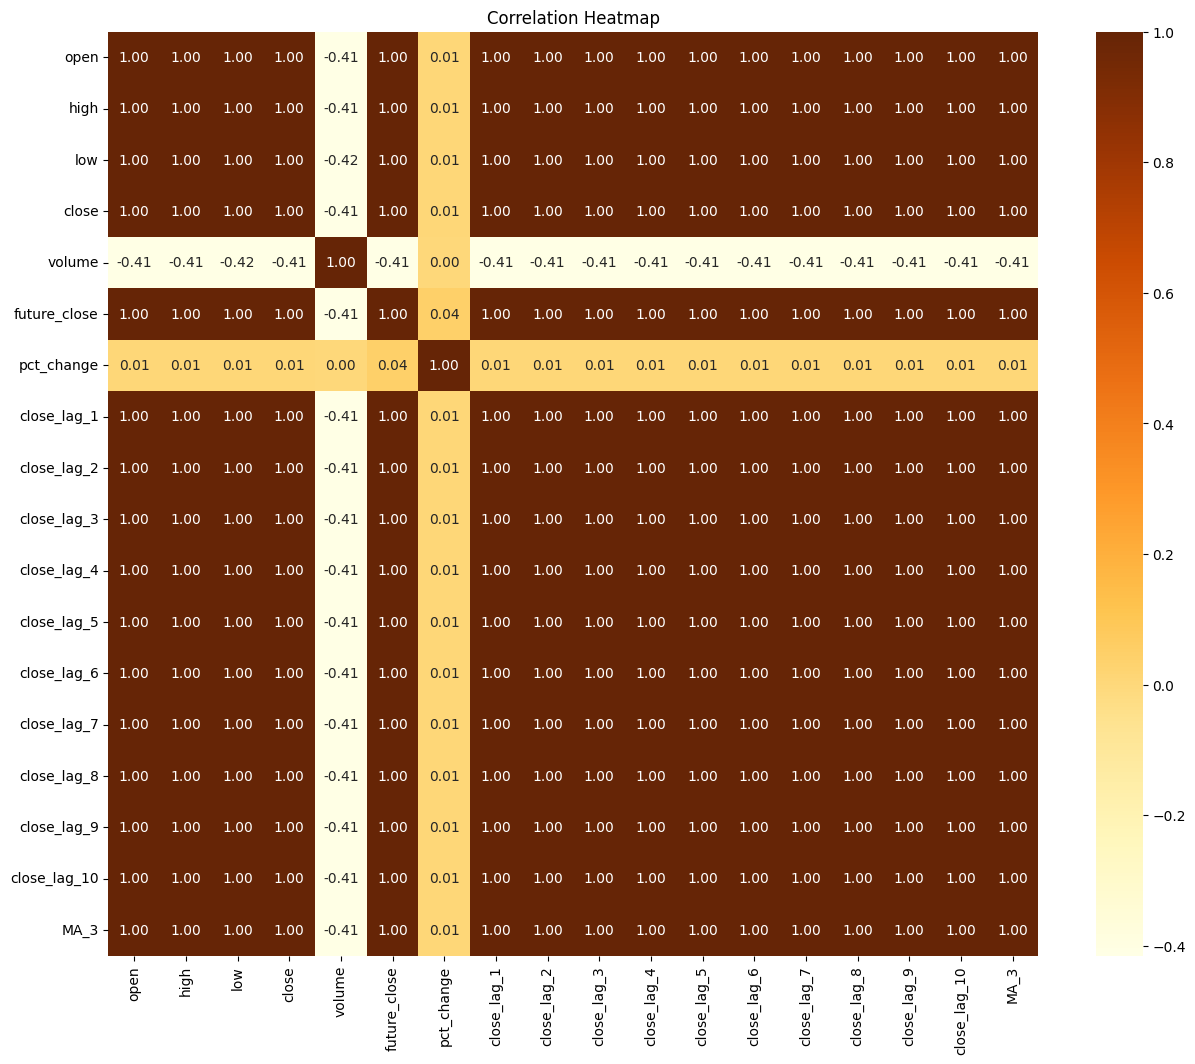

In [12]:
# Plotting the correlation heatmap
from data_visualization import plot_correlation_heatmap
plot_correlation_heatmap(resampled_data)

## Step 5.2: Plotting the graph of the data (Train Test Split)

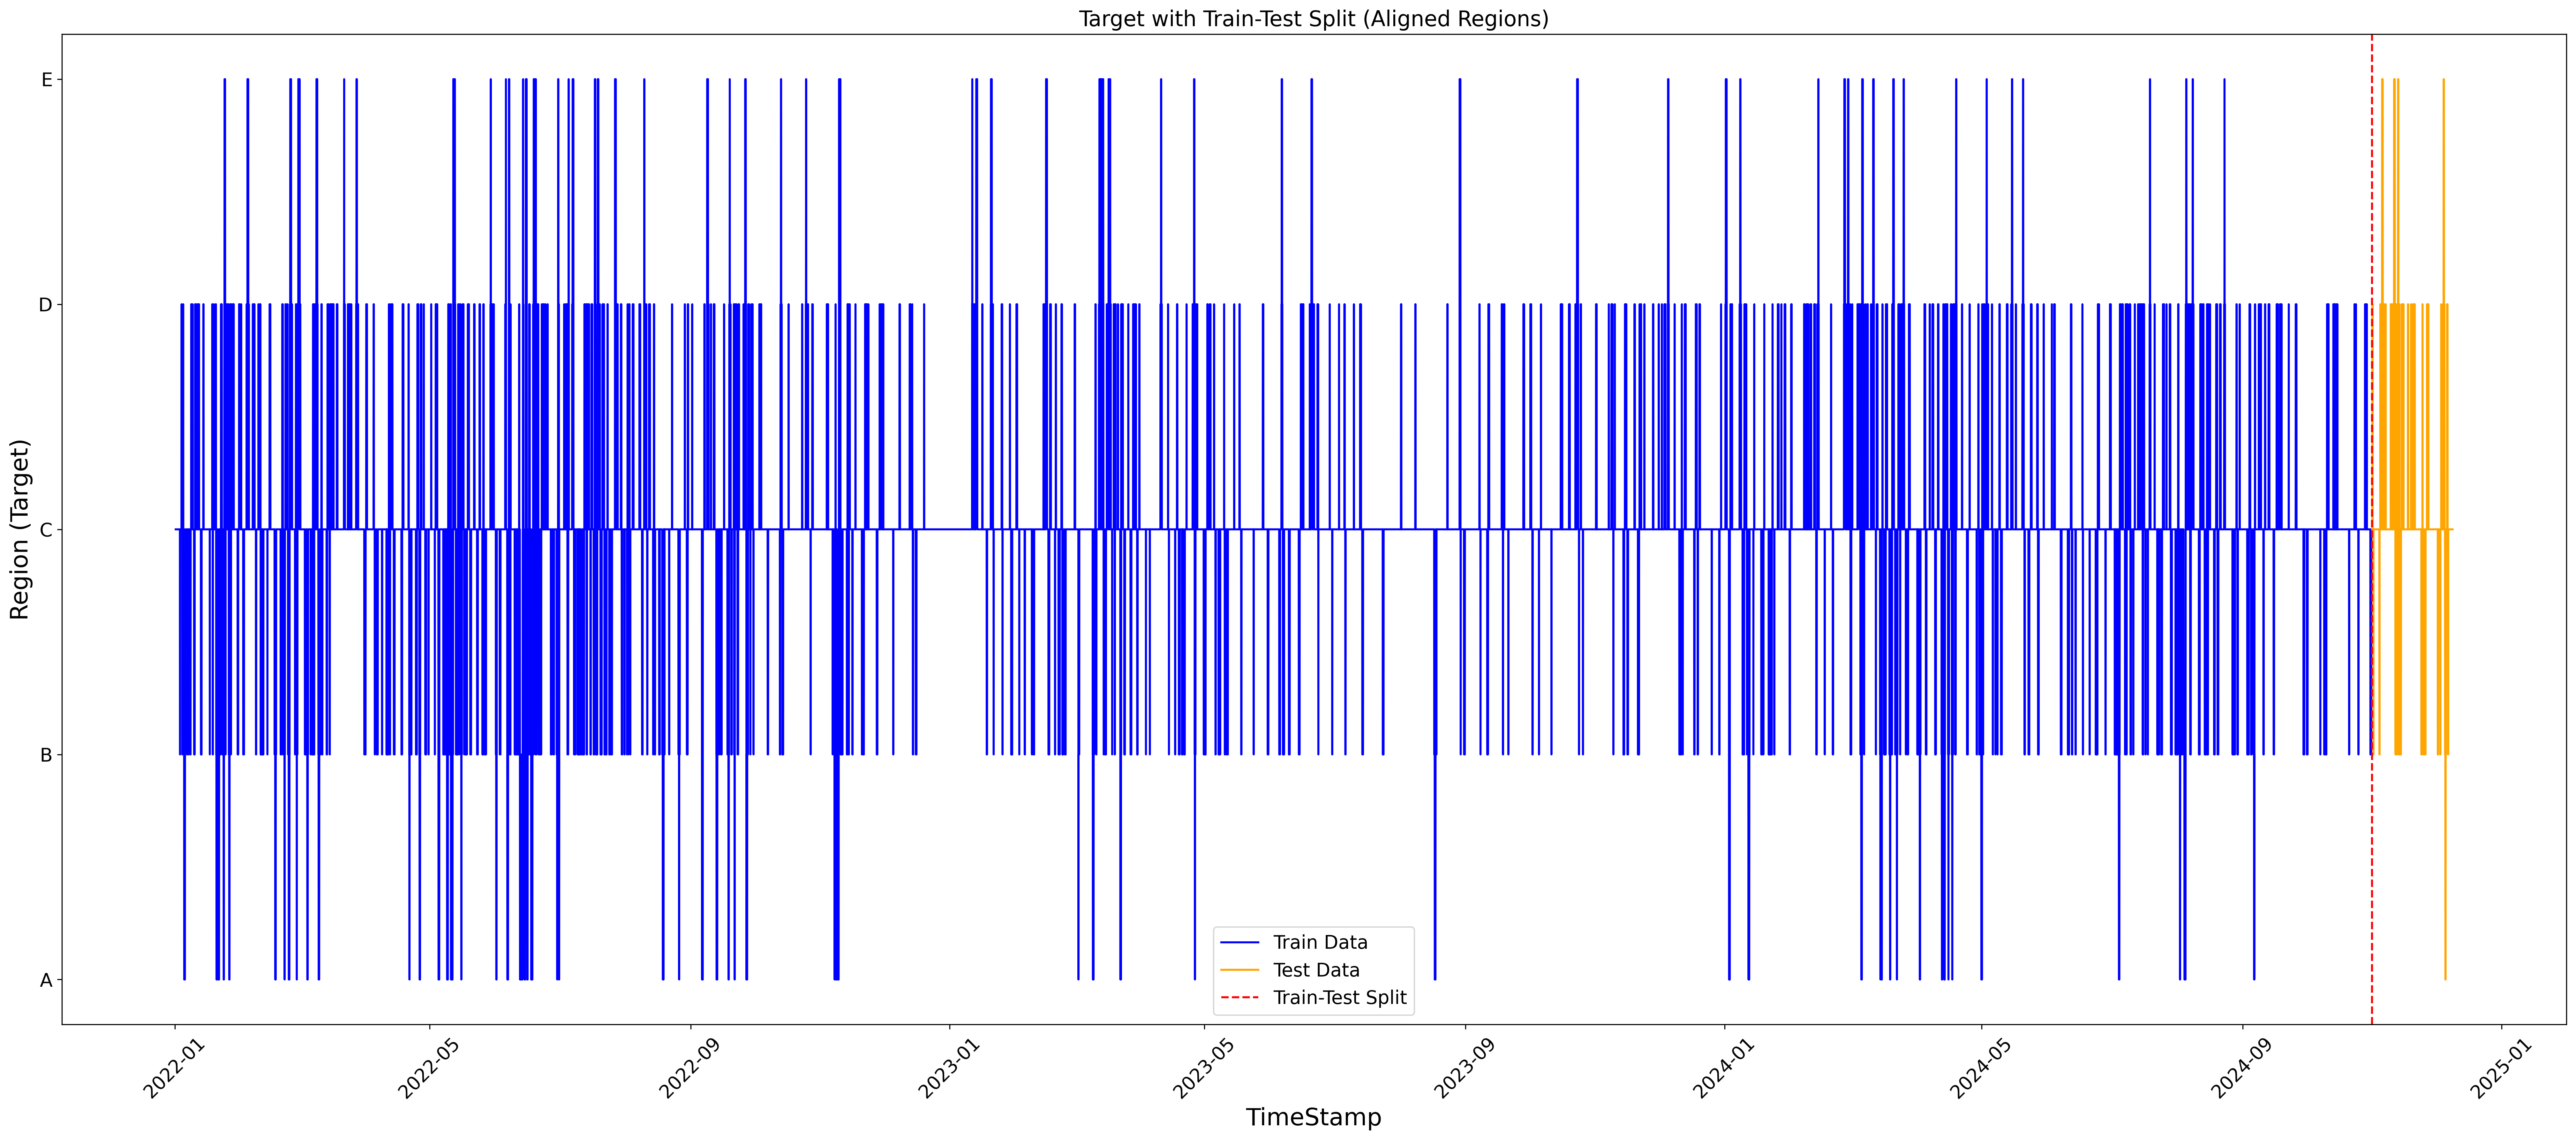

In [13]:
from data_visualization import plot_train_test_split
plot_train_test_split(resampled_data)

# Based on what is assumed we can split the data this way:
#train_data = resampled_data[resampled_data.index < '2024-11-01']
#test_data = resampled_data[resampled_data.index >= '2024-11-01']

## Step 5.3: Plotting the dynamic graph of the data

In [14]:

from data_visualization import plot_train_test_split_dynamic
plot_train_test_split_dynamic(resampled_data)